# Standard Imports

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Reading In-Data 

In [3]:
df = pd.read_csv("./DATA/cleaned_data.csv")

In [5]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class'] 

In [7]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [8]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

## Converting NumPy Arrays to Tensors

In [9]:
cats = torch.tensor(cats, dtype=torch.int64) 

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [10]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [11]:
conts.type()

'torch.FloatTensor'

In [12]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [13]:
cats.shape

torch.Size([120000, 3])

In [14]:
conts.shape

torch.Size([120000, 6])

In [15]:
y.shape

torch.Size([120000, 1])

### Setting an embedding size

In [16]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

### Defining a Tabular Model 

In [17]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [19]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Defining Loss Functions and Optimizer

In [20]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train-Test Split

In [21]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

### Model Training

In [22]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

epoch:   1  loss: 0.96259791
epoch:  26  loss: 0.56580502
epoch:  51  loss: 0.46546677
epoch:  76  loss: 0.40953931
epoch: 101  loss: 0.37147576
epoch: 126  loss: 0.34558195
epoch: 151  loss: 0.32536989
epoch: 176  loss: 0.31341472
epoch: 201  loss: 0.30432674
epoch: 226  loss: 0.29992101
epoch: 251  loss: 0.29627600
epoch: 276  loss: 0.29229194
epoch: 300  loss: 0.28960612

Duration: 226 seconds


### Plotting the loss function

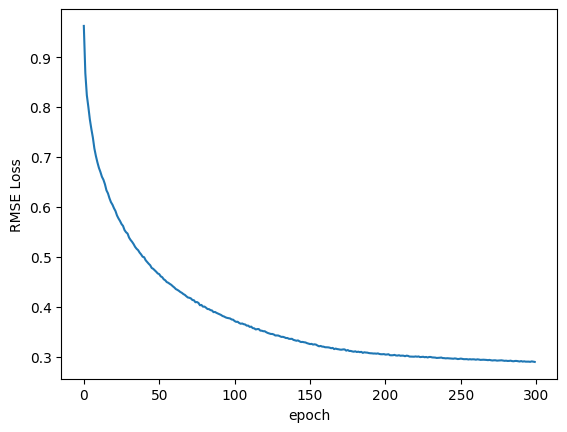

In [25]:
losses = [loss.detach().item() for loss in losses]

plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Model Validation

In [26]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 0.28564566


In [27]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   0.1262   0.0000   0.1262
 2.   0.8220   0.0000   0.8220
 3.   0.0665   0.0000   0.0665
 4.   0.8310   1.0000   0.1690
 5.  -0.0410   0.0000   0.0410
 6.  -0.0010   0.0000   0.0010
 7.   0.0188   0.0000   0.0188
 8.   0.7944   1.0000   0.2056
 9.   0.1085   0.0000   0.1085
10.   0.9352   1.0000   0.0648
11.  -0.1149   0.0000   0.1149
12.   0.0268   0.0000   0.0268
13.   0.1336   0.0000   0.1336
14.   0.9986   1.0000   0.0014
15.   0.0178   0.0000   0.0178
16.   0.9206   1.0000   0.0794
17.   0.0559   1.0000   0.9441
18.   0.0746   0.0000   0.0746
19.   0.3281   0.0000   0.3281
20.   0.0052   0.0000   0.0052
21.   0.8791   1.0000   0.1209
22.   0.6674   1.0000   0.3326
23.   1.0471   1.0000   0.0471
24.   0.9698   1.0000   0.0302
25.   0.5700   1.0000   0.4300
26.  -0.0219   0.0000   0.0219
27.   0.0562   0.0000   0.0562
28.   0.0309   0.0000   0.0309
29.   1.0116   1.0000   0.0116
30.  -0.0654   0.0000   0.0654
31.   0.0454   0.0000   0.0454
32.   1.

In [28]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')